# Importing Necessary Libraries

In [ ]:
# Importing necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation
import os  # For interacting with the operating system
import csv  # For reading and writing CSV files
from sklearn.model_selection import train_test_split  # For splitting data into training and validation sets
import torchvision  # For computer vision tasks
from PIL import Image  # For image processing
from torch.utils.data import Dataset  # For creating custom datasets in PyTorch
from torchvision import datasets, transforms  # For working with image datasets and transformations
import torch  # PyTorch library
import torch.utils.data as datatorch  # PyTorch's data loading utility
import torch.nn as nn  # PyTorch's neural network module
from sklearn.metrics import f1_score  # For calculating F1 score
import torch.backends.cudnn as cudnn  # For optimizing GPU performance with CuDNN
import time  # For measuring time
import datetime  # For working with dates and times
from pathlib import Path  # For working with file paths
from keras.applications.vgg16 import VGG16  # Pre-trained VGG16 model


# Storing Annotations in Variables and setting there datatype to string

In [28]:
# Loading training triplets from a CSV file into a NumPy array
train_triplets = np.array(pd.read_csv('../input/food-iml/train_triplets.txt', sep=' ', header=None, dtype=str))

# Loading test triplets from a CSV file into a NumPy array
test_triplets = np.array(pd.read_csv('../input/food-iml/test_triplets.txt', sep=' ', header=None, dtype=str))


# Splitting Annotations into train 80% and test 20%

In [29]:
# Splitting the training triplets into training and validation sets
train_triplets, val_triplets = train_test_split(train_triplets, test_size=0.2)

# Printing the shapes of the training and validation sets
print(train_triplets.shape, val_triplets.shape)


(47612, 3) (11903, 3)


In [30]:
# Creating validation labels
val_labels = np.int64(np.ones((val_triplets.shape[0],)))



In [31]:
# Setting the path to the training directory
train_dir = Path('../input/food-iml/food/food')

# Listing files in the training directory
train_files = os.listdir(train_dir)

# Listing files in the training directory for testing (this seems redundant)
test_files = os.listdir(train_dir)

# Counting the number of files in the training directory
number_files = len(test_files)

# Printing the number of files
print(number_files)


10000


# ImageTriplesSet Class

## Description

This class represents a dataset for image triples. It allows for easy loading of image triples from file names.

## Constructor

### `__init__(self, file_array, dir, mode='train', transform=None, labels=None)`

Initializes the ImageTriplesSet object.

#### Parameters:

- `file_array` (list): List of tuples containing file names.
- `dir` (str): Directory containing the image files.
- `mode` (str): Mode of the dataset. Default is 'train'.
- `transform` (callable, optional): Optional transform to be applied on a sample.
- `labels` (list, optional): List of labels associated with the dataset.

## Methods

### `__len__(self) -> int`

Returns the length of the dataset.

### `__getitem__(self, idx) -> Tuple[Union[PIL.Image.Image, np.ndarray]]`

Returns a triple of images and optionally their labels.

#### Parameters:

- `idx` (int): Index of the item to retrieve.

#### Returns:

- If labels are not provided: Tuple containing three images (img1, img2, img3).
- If labels are provided: Tuple containing three images and their corresponding labels (img1, img2, img3, labels).

#### Raises:

- IndexError: If the index is out of range.



In [32]:
class ImageTriplesSet(Dataset):
    def __init__(self, file_array, dir, mode='train', transform=None, labels=None):
        """
        Constructor method for the ImageTriplesSet class.

        Args:
            file_array (list): A list of triplets, where each triplet contains file names of images.
            dir (str): The directory where the image files are located.
            mode (str): The mode of the dataset (default is 'train').
            transform (callable, optional): Optional image transformation to be applied.
            labels (list, optional): Optional labels associated with the triplets.
        """
        # Initializing instance variables
        self.triple_list = list(map(tuple, file_array))  # Converting file_array to a list of tuples
        self.mode = mode  # Setting the mode of the dataset
        self.labels = labels  # Setting the labels
        self.dir = dir  # Setting the directory path
        self.transform = transform  # Setting the image transformation

    def __len__(self):
        """
        Method to return the total number of triplets in the dataset.

        Returns:
            int: The total number of triplets.
        """
        return len(self.triple_list)

    def __getitem__(self, idx):
        """
        Method to get a specific triplet of images from the dataset.

        Args:
            idx (int): The index of the triplet to retrieve.

        Returns:
            tuple: A tuple containing three images (img1, img2, img3), and optionally labels.
        """
        # Opening and loading images from the directory based on the triplet index
        img1 = Image.open(os.path.join(self.dir, self.triple_list[idx][0] + '.jpg'))
        img2 = Image.open(os.path.join(self.dir, self.triple_list[idx][1] + '.jpg'))
        img3 = Image.open(os.path.join(self.dir, self.triple_list[idx][2] + '.jpg'))

        # Applying image transformations if specified
        if self.transform is not None:
            img1 = self.transform(img1).numpy()
            img2 = self.transform(img2).numpy()
            img3 = self.transform(img3).numpy()

        # Returning the images and optionally labels
        if self.labels is None:
            return img1, img2, img3
        else:
            return img1, img2, img3, self.labels[idx]


# Data Transform

## Description

This data transform is a composition of several image transformations. It resizes images to 229x229, then performs a center crop of 224x224, converts the images to PyTorch tensors, and finally normalizes them using the specified mean and standard deviation.

## Transformations:

1. Resize: Resizes the input image to the specified size (229x229).
2. CenterCrop: Crops the center of the image to the specified size (224x224).
3. ToTensor: Converts the image to a PyTorch tensor.
4. Normalize: Normalizes the tensor with the given mean and standard deviation.

## Parameters:

- **Resize**: Target size of the resized image (229x229).
- **CenterCrop**: Output size of the center-cropped image (224x224).
- **ToTensor**: No parameters.
- **Normalize**: Mean and standard deviation used for normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225].

# Dataset Initialization

## Description

Three datasets (train_dataset, val_dataset, test_dataset) are initialized using the `ImageTriplesSet` class with specified parameters.

## Parameters:

- `train_triplets`: List of triplets for the training dataset.
- `val_triplets`: List of triplets for the validation dataset.
- `test_triplets`: List of triplets for the test dataset.
- `train_dir`: Directory containing the image files for training.
- `mode`: Mode of the dataset. Default is 'train' for training and validation datasets, and 'test' for the test dataset.
- `transform`: Data transformation to be applied to the images.
- `labels`: Optional list of labels associated with the dataset.

## Initialization:



In [33]:
# Define image transformations to be applied
data_transform = transforms.Compose([
    transforms.Resize(229),  # Resize the image to a square with size 229x229 pixels
    transforms.CenterCrop(224),  # Crop the center of the image to size 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image pixel values
])

# Create training dataset with specified transformations and no labels
train_dataset = ImageTriplesSet(train_triplets, train_dir, transform=data_transform, labels=None)

# Create validation dataset with specified transformations and no labels
val_dataset = ImageTriplesSet(val_triplets, train_dir, transform=data_transform, labels=None)

# Create test dataset with specified transformations and no labels
test_dataset = ImageTriplesSet(test_triplets, train_dir, mode="test", transform=data_transform, labels=None)


# Importing torchvision.models Module

The `torchvision.models` module provides pre-trained models for computer vision tasks. It is imported under the alias `models`.



In [35]:
# Importing the VGG16 model from torchvision.models
import torchvision.models as models

# Checking for GPU availability and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Printing the device (either "cuda" or "cpu")
print(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


# Model Training Parameters

## Description

Defines the parameters used for training a machine learning model.

## Parameters:

- `learning_rate`: The learning rate used for optimization.
- `batch_size`: The number of samples in each batch during training.
- `epochs`: The number of epochs for training the model.
- `logstep`: The frequency at which training statistics are logged.

In [36]:
# Set the learning rate for training
learning_rate = 0.0001

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 4

# Calculate the logstep for logging training progress
logstep = int(1000 // batch_size)


# Training Setup

## Description

Defines the setup for training the machine learning model, including data loading, device selection, loss function, and optimizer.


In [38]:
# Create a DataLoader for the training dataset
train_loader = datatorch.DataLoader(dataset=train_dataset, shuffle=False, batch_size=batch_size)

# Check for GPU availability and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model = model.to(device)

# Define the criterion for the loss function
criterion = nn.TripletMarginLoss(margin=1.0, p=2)

# Define the optimizer for updating model parameters
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5, nesterov=True)


In [39]:
# List to store training loss values during each iteration
training_loss_vec = []

# List to store training accuracy values during each iteration
training_accuracy_vec = []

# List to store validation F1 scores after each epoch
val_f1_score = []


# Explanation of Code Snippet

## Description

This code snippet represents a training loop for a machine learning model using PyTorch. It iterates over multiple epochs, loading batches of data, computing the loss, and updating the model parameters through backpropagation.


In [40]:
# Record the starting time of the training process
start = time.time()

# Set the model in training mode
model.train()

# Iterate over each epoch
for e in range(epochs):
    
    # Initialize variables to track training loss and accuracy for this epoch
    training_loss = 0.
    training_accuracy = 0.
    
    # Iterate over batches of data in the training DataLoader
    for idx, (data1, data2, data3) in enumerate(train_loader):
        
        # Transfer data batches to the appropriate device (GPU if available)
        data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
        
        # Forward pass: compute embeddings for anchor, positive, and negative examples
        embedded_a, embedded_p, embedded_n = model(data1), model(data2), model(data3)
        
        # Compute the triplet loss
        loss = criterion(embedded_a, embedded_p, embedded_n)
        
        # Zero the gradients to prevent accumulation
        optimizer.zero_grad()
        
        # Backpropagation: compute gradients of the loss with respect to model parameters
        loss.backward()
        
        # Update model parameters using the optimizer
        optimizer.step()
        
        # Update the total training loss for this epoch
        training_loss += loss.item()
        
        # Log training loss and update training accuracy every 'logstep' iterations
        if (idx) % logstep == 0:
            
            # Append normalized training loss to the list
            training_loss_vec.append(training_loss/logstep)
            
            # Print training loss at the current iteration
            print('[%d, %5d] training loss: %.5f' % (e + 1, idx + 1, training_loss/logstep))
            
            # Reset training loss and accuracy for the next logstep
            training_loss, training_accuracy = 0., 0.

# Record the ending time of the training process
end = time.time()

# Print the total training time in a human-readable format
print(str(datetime.timedelta(seconds=end - start)))

# Create a DataLoader for the validation dataset
val_loader = datatorch.DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)


[1,     1] training loss: 0.26028
[1,    32] training loss: 3.09971
[1,    63] training loss: 1.35549
[1,    94] training loss: 1.04573
[1,   125] training loss: 0.95749
[1,   156] training loss: 0.89960
[1,   187] training loss: 0.89261
[1,   218] training loss: 0.88458
[1,   249] training loss: 0.88132
[1,   280] training loss: 0.83943
[1,   311] training loss: 0.79934
[1,   342] training loss: 0.80994
[1,   373] training loss: 0.84625
[1,   404] training loss: 0.76371
[1,   435] training loss: 0.79864
[1,   466] training loss: 0.83128
[1,   497] training loss: 0.79856
[1,   528] training loss: 0.77988
[1,   559] training loss: 0.80983
[1,   590] training loss: 0.79231
[1,   621] training loss: 0.80028
[1,   652] training loss: 0.78110
[1,   683] training loss: 0.76987
[1,   714] training loss: 0.77268
[1,   745] training loss: 0.78087
[1,   776] training loss: 0.77111
[1,   807] training loss: 0.71585
[1,   838] training loss: 0.74614
[1,   869] training loss: 0.76741
[1,   900] tra

# Explanation of Code Snippet

## Description

This code snippet represents the evaluation phase for a machine learning model using PyTorch. It evaluates the model on a validation dataset, computes predictions, and calculates the F1 score.


In [41]:
# Record the starting time for prediction on validation data
start = time.time()

# Initialize an empty list to store predicted labels for validation data
val_labels_pred = []

# Set the model to evaluation mode
model.eval()

# Iterate over batches of data in the validation DataLoader
for idx, (data1, data2, data3) in enumerate(val_loader):
    
    # Transfer data batches to the appropriate device (GPU if available)
    data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
    
    # Forward pass: compute embeddings for anchor, positive, and negative examples
    embedded_1, embedded_2, embedded_3 = model(data1), model(data2), model(data3)
    
    # Compare distances between embeddings to predict labels
    if torch.dist(embedded_1, embedded_3, 1) >= torch.dist(embedded_1, embedded_2, 1):
        val_labels_pred.append(1)  # Append 1 if distance between embedded_1 and embedded_3 is greater
    else:
        val_labels_pred.append(0)  # Append 0 otherwise

# Calculate F1 score using predicted labels and ground truth labels for validation data
f1 = f1_score(val_labels_pred, val_labels)

# Print the F1 score
print(f1)

# Print the length of the predicted labels list
print(len(val_labels_pred))

# Create a DataLoader for the test dataset
test_loader = datatorch.DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

# Record the ending time for prediction on validation data
end = time.time()


0.872020848140251
11903


# Explanation of Code Snippet

## Description

This code snippet represents the testing phase for a machine learning model using PyTorch. It evaluates the model on a test dataset, computes predictions, and records the time taken for inference.


In [42]:
test_triplets_pred = []
model.eval()
start = time.time()
for idx, (data1, data2, data3) in enumerate(test_loader):
    data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
    embedded_1, embedded_2, embedded_3 = model(data1), model(data2), model(data3)
    if torch.dist(embedded_1,embedded_3,1)>=torch.dist(embedded_1,embedded_2,1):
        test_triplets_pred.append(str(1))
    else:
        test_triplets_pred.append(str(0))
end = time.time()
print(str(datetime.timedelta(seconds= end - start)))

0:28:06.035285


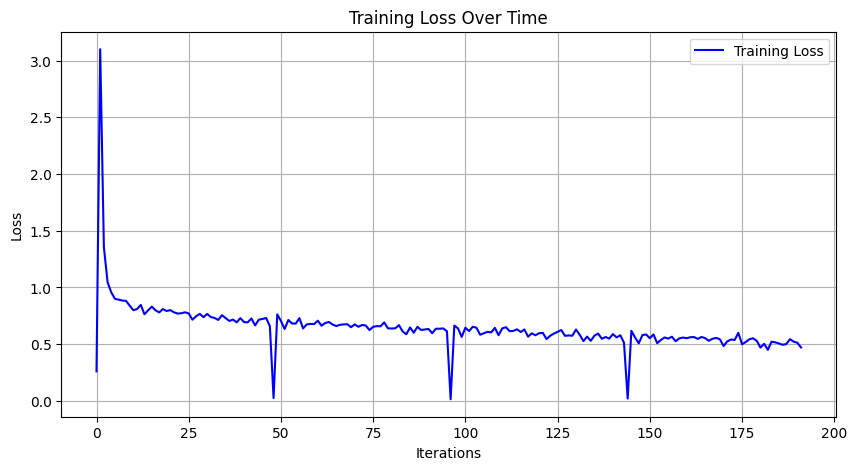

In [44]:
import matplotlib.pyplot as plt

# Plotting Training Loss Over Time
plt.figure(figsize=(10, 5))
plt.plot(training_loss_vec, label='Training Loss', color='blue')
plt.title('Training Loss Over Time')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



# Explanation of Code Snippet

## Description

This code snippet writes the predicted labels for the test dataset to an output file named `'output.txt'`.

## Initialization

```python
file_name = 'output.txt'


In [45]:
file_name = 'output.txt'
with open(file_name, 'w') as f:
    for item in test_triplets_pred:
        f.write(item + '\n')